# Tutorial: Regularization, Model Selection and Evaluation

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F04_tutorial_regularization_selection_evaluation.ipynb)

Tutorial to the class [Regularization, Model Selection and Evaluation](05_regularization_selection_evaluation.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Apply regularization methods: Ridge and Lasso
- Compute and plot validation curves
- Compare $k$-nearest neighbors to Ridge/Lasso
</div>

## Scientific objective

To predict the France average wind capacity factor from the geopotential height at 500hPa over the Euro-Atlantic sector.

## Dataset presentation

- Input:
  - [Geopotential height](https://en.wikipedia.org/wiki/Geopotential_height) at 500hPa
    - Domain: North Atlantic
    - Spatial resolution: $0.5° \times 0.625°$
    - Time resolution: monthly
    - Period: 1980-2021
    - Units: m
    - Source: [MERRA-2 reanalysis](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/)
- Target:
  - Onshore wind capacity factors
    - Domain: Metropolitan France
    - Spatial resolution: regional mean
    - Time resolution: daily
    - Period: 2014-2021
    - Units:
    - Source: [RTE](https://opendata.reseaux-energies.fr/)

## Getting ready

### Reading the wind capacity factor data

- Let us follow the same procedure as in [Tutorial: Supervised Learning Problem and Least Squares](02_tutorial_supervised_learning_problem_ols.ipynb) to import the required modules, read the data and select the domain but for the onshore wind capacity factors instead of the electricity demand.
- We also compute monthly averages from the daily data since the we are only interested in predicting the monthly wind capacity factors.

In [1]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis module
import pandas as pd
# Structured dataset analysis module
import xarray as xr
# Plot module
import matplotlib.pyplot as plt
# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Matplotlib configuration
plt.rc('font', size=14)

# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict(index_col=0, parse_dates=True) 

# Define electricity demand filepath and label
windcf_filename = 'reseaux_energies_capacityfactor_wind-onshore.csv'
windcf_filepath = Path(data_dir, windcf_filename)
windcf_label = 'Wind capacity factor'

# Read windcf data with pandas                                                                                                                                                
df_windcf_daily = pd.read_csv(windcf_filepath, **kwargs_read_csv)

# Select domain
# REGION_NAME = 'Bretagne'
REGION_NAME = 'National'
if REGION_NAME == 'National':
    df_windcf_daily_reg = df_windcf_daily.mean('columns')
    df_windcf_daily_reg.name = REGION_NAME
else:
    df_windcf_daily_reg = df_windcf_daily[REGION_NAME]

# Resample wind capacity factor from daily to monthly means
df_windcf_reg = df_windcf_daily_reg.resample('MS').mean()

### Reading the geopotential height data

- The geopotential height data is in the NetCDF format (structured binary data) and cannot be read as text.
We use the `xarray` module instead to read it.
- We also divide the resolution of the gridded data by a factor 4 in both horizontal dimensions.

In [2]:
# Define temperature filepath and label
START_DATE = '19800101'
END_DATE = '20220101'
z500_filename = 'merra2_analyze_height_500_month_{}-{}.nc'.format(START_DATE, END_DATE)
z500_filepath = Path(data_dir, z500_filename)
z500_label = 'Geopotential height (m)'

# Read geopotential height dataset with xarray                                                                                                                                
ds = xr.load_dataset(z500_filepath)

# Select geopotential height variable                                                                                                                                         
z500_name = 'height_500'                                                                                                                                                     
da_z500_hr = ds[z500_name]

# Downsample geopotential height
N_GRID_AVG = 8
da_z500 = da_z500_hr.coarsen(lat=N_GRID_AVG, boundary='trim').mean().coarsen(                                                                                                 
    lon=N_GRID_AVG, boundary='trim').mean()

ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

> ***Question***
> - Print the geopotential height `DataArray` and make sense of what you read.
> - How many variables constitute the geopotential height field?

In [ ]:
da_z500.dims
da_z500.shape
print(da_z500.lat, da_z500.lon, da_z500.time)
#5*9=45


<xarray.DataArray 'lat' (lat: 5)> Size: 40B
array([ 7.75, 23.75, 39.75, 55.75, 71.75])
Coordinates:
  * lat      (lat) float64 40B 7.75 23.75 39.75 55.75 71.75
Attributes:
    long_name:     latitude
    units:         degrees_north
    vmax:          1000000000000000.0
    vmin:          -1000000000000000.0
    valid_range:   [-1.e+15  1.e+15]
    origname:      lat
    fullnamepath:  /lat <xarray.DataArray 'lon' (lon: 9)> Size: 72B
array([-90.3125, -70.3125, -50.3125, -30.3125, -10.3125,   9.6875,  29.6875,
        49.6875,  69.6875])
Coordinates:
  * lon      (lon) float64 72B -90.31 -70.31 -50.31 -30.31 ... 29.69 49.69 69.69
Attributes:
    long_name:     longitude
    units:         degrees_east
    vmax:          1000000000000000.0
    vmin:          -1000000000000000.0
    valid_range:   [-1.e+15  1.e+15]
    origname:      lon
    fullnamepath:  /lon <xarray.DataArray 'time' (time: 504)> Size: 4kB
array(['1980-01-01T00:00:00.000000000', '1980-02-01T00:00:00.000000000',
       '

### Representing the first moments of the geopotential height field

> ***Question***
> - Compute the mean and the variance of the geopotential height with the `mean` and `var` methods.
> - Plot the mean with the `plot` method.
> - Do a filled-contour plot of the variance with the `plot.contourf` method.

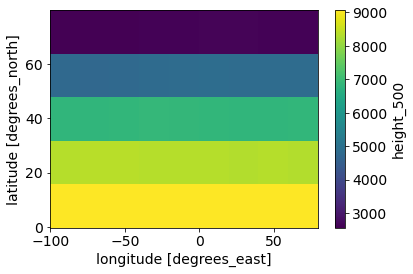

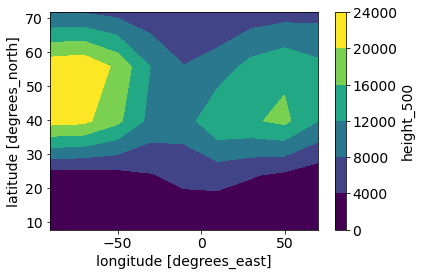

In [ ]:
# answer cell
plt.figure()
da_z500.mean('time').plot()
plt.figure()
da_z500.var('time').plot.contourf()
plt.show()
#plt.contour(,da_z500.lon, da_z500.lat, 'o')


- A strong part of the wind capacity factor signals is the seasonal cycle.
The latter can be estimated from historical data and does not need to be predicted from the geopotential height.
We thus remove it from both the geopotential height and the wind capacity factor.
- We also keep only the dates that are common to both datasets so as to have pairs of feature and target data points used to solve the supervised learning problem.
- Finally, we save the time index and the number of complete years in the dataset for later.

In [ ]:
# Remove seasonal cycle from wind capacity factor
da_windcf_reg = df_windcf_reg.to_xarray()                                                                                                                                 
gp_windcf_cycle = da_windcf_reg.groupby('time.month')                                                                                                                     
da_windcf_anom = gp_windcf_cycle - gp_windcf_cycle.mean('time')                                                                                                           
df_windcf_anom = da_windcf_anom.drop('month').to_dataframe()[REGION_NAME]

# Remove seasonal cycle from geopotential height or not
gp_z500_cycle = da_z500.groupby('time.month')                                                                                                                             
da_z500_anom = gp_z500_cycle - gp_z500_cycle.mean('time')

# Convert to pandas with grid points as columns                                                                                                                               
df_z500_anom = da_z500_anom.stack(latlon=('lat', 'lon')).to_dataframe()[
    z500_name].unstack(0).transpose()
    
# Select common index                                                                                                                                                         
idx = df_z500_anom.index.intersection(df_windcf_anom.index)                                                                                                                   
df_z500_anom = df_z500_anom.loc[idx]                                                                                                                                          
df_windcf_anom = df_windcf_anom.loc[idx]                                                                                                                                      
                                                                                                                                                                              
# Number of years in dataset                                                                                                                                                  
time = df_windcf_anom.index                                                                                                                                                   
n_years = time.year.max() - time.year.min() + 1

C:\Users\dalpt\AppData\Local\Temp\ipykernel_2608\1797174059.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  df_windcf_anom = da_windcf_anom.drop('month').to_dataframe()[REGION_NAME]


> ***Question***
> - How many years of common data is there?
> - Plot the time series of the spatially averaged geopotential height and of the national wind capacity factor.
> - Compute the correlation between the spatial average of the geopotential height and the wind capacity factor.

In [ ]:
# answer cell
print(time.year.max() - time.year.min() + 1)
plt.figure()
df_z500_anom_avg=df_z500_anom.mean('columns')
print(df_z500_anom_avg)



NameError: name 'time' is not defined

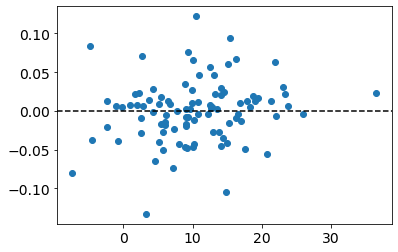

In [ ]:
df_windcf_anom.head()
mean=df_windcf_anom.mean()
plt.scatter(df_z500_anom_avg, df_windcf_anom)
plt.axhline(mean, color='k', linestyle='--')
plt.show()

In [ ]:
corr=np.corrcoef(df_z500_anom_avg, df_windcf_anom)
print(f'Correlation coefficient between geopotential height and wind anomalies {corr[0,1]}')

Correlation coefficient between geopotential height and wind anomalies 0.16309993444971618


## Regularization

We want to learn to predict the national wind capacity factor from the geopotential height at different grid points using a linear model.

Since the number of input variables, we need to take care of avoiding overfitting.

To do so, we apply different regularization techniques.

### Ridge regression

> ***Question***
> - Apply the ridge regression using `Ridge` from `sklearn.linear_model` to predict the national wind capacity factor from the geopotential height field for an arbitrary regularization parameter value of `10**5`.
> - Plot the histogram estimate of the probability density function of the model coefficients and print the intercept.
> - How does the distribution of the coefficients change when you increase or decrease the regularization coefficient?
> - Explain this behavior based on what you have learned in class.

R^2 for alpha=10^5: 0.5351446944978336
R^2 for alpha=10^4: 0.7734940935474635
R^2 for alpha=10^3: 0.8174404659234722


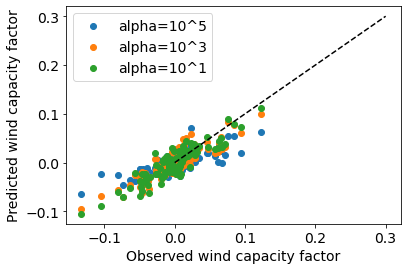

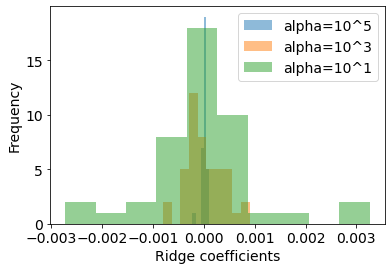

In [ ]:
# answer cell
import sklearn.linear_model as lm
import sklearn.model_selection as ms
import sklearn.metrics as skm   
X=df_z500_anom.values
y=df_windcf_anom.values

ridge_1=lm.Ridge(alpha=10**5)

ridge_2=lm.Ridge(alpha=10**3)

ridge_3=lm.Ridge(alpha=10**1)
ridge_1.fit(X,y)
ridge_2.fit(X,y)
ridge_3.fit(X,y)
y_pred_1=ridge_1.predict(X)
y_pred_2=ridge_2.predict(X)
y_pred_3=ridge_3.predict(X)
x_value=np.linspace(X.min(),X.max(),100)


print(f'R^2 for alpha=10^5: {skm.r2_score(y, y_pred_1)}')
print(f'R^2 for alpha=10^4: {skm.r2_score(y, y_pred_2)}')
print(f'R^2 for alpha=10^3: {skm.r2_score(y, y_pred_3)}')
plt.figure()
plt.scatter(y, y_pred_1, label='alpha=10^5')
plt.scatter(y, y_pred_2, label='alpha=10^3')
plt.scatter(y, y_pred_3, label='alpha=10^1')
plt.plot([0,0.3],[0,0.3],'k--')
plt.xlabel('Observed wind capacity factor')
plt.ylabel('Predicted wind capacity factor')
plt.legend()
plt.show()
plt.figure()
plt.hist(ridge_1.coef_, alpha=0.5, label='alpha=10^5')
plt.hist(ridge_2.coef_, alpha=0.5, label='alpha=10^3')
plt.hist(ridge_3.coef_, alpha=0.5, label='alpha=10^1')
plt.xlabel('Ridge coefficients')
plt.ylabel('Frequency')
plt.legend()
plt.show()



Answer:

> ***Question***
> - Compute the corresponding validation curves. To do so:
>   - Leave aside a year or more of test data (it will be used later to test the model with regularization).
>   - Compute and plot the train and validation error (using cross-validation) for varying values of the regularization parameter.
> - What is the best value of the regularization parameter according to your estimations?
> - Is there any overfitting and/or underfitting occurring here?

In [ ]:
# answer cell
nb_test_yrs=2
n_test=12*nb_test_yrs
complexity_rng=np.logspace(0,10,50)
X_cv=X[:-n_test]; y_cv=y[:-n_test]

Answer:

> ***Question***
> - Compare the distribution of the model coefficients for the best value of the regularization parameter to that of the ordinary least squares coefficients.

In [ ]:
# answer cell


Answer: 

> ***Question***
> - Give an estimate the prediction error conditioned on some train dataset for the best choice or regularization parameter value.
> - Compare the test value of the score to its validation value.
> - Evaluate and discuss the sensitivity of the test score to the number of test years retained.

In [ ]:
# answer cell


Answer:

> ***Question (optional)***
> - Use nested cross-validation to estimated the expected prediction error for the best choice of regularization parameter value.
> - How does the this value of the test score compare with the one conditionned on a few years of data computed in the previous section? Discuss this result.

In [ ]:
# answer cell


Answer:

### Lasso regression

> ***Question***
> - Same questions as for the ridge but for the Lasso (using `Lasso` from `sklearn.linear_model`).
> - How do the coefficients evolve compared to the Ridge?

In [ ]:
# answer cell


Answer:

## $K$-nearest neighbor model

> ***Question (optional)***
> - Compute and plot the validation curve for the $k$-nearest neighbor model using `KNeighborsRegressor` from `sklearn.neighbors` for varying number of neighbors.
> - For which value of $k$ is the score best? Represent the best prediction above the scatter plot of the train data.
> - Is there any overfitting occurring?
> - How does the best $k$-nearest neighbor model performs compared to the linear models analyzed so far?

In [ ]:
# answer cell


Answer:

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>